<a href="https://colab.research.google.com/github/jingvf/IDS/blob/main/Pytorch_CNNAttention_DP_Adam-SGD%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
from opacus import PrivacyEngine
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# 加载数据
data_path = '/content/drive/MyDrive/2025paper/dataset/small_dataset.csv'  # 替换为你的数据路径
df = pd.read_csv(data_path)

Using device: cuda


In [5]:
!pip install opacus -qq

In [6]:
# 输出类别数量
num_classes = df['Class'].nunique()
print(f"总类别数: {num_classes}")

# 输出每个类别的数量
class_counts = df['Class'].value_counts()
print("每个类别的样本数量：")
print(class_counts)
print(df.head())

总类别数: 5
每个类别的样本数量：
Class
Normal          946844
SpoofingRPM      65490
SpoofingGear     59725
DoS              10553
Fuzzy             8967
Name: count, dtype: int64
      Timestamp CAN ID  DLC Data[0] Data[1] Data[2] Data[3] Data[4] Data[5]  \
0  1.478192e+09    316    8      45      29      24      ff      29      24   
1  1.478192e+09    316    8      45      29      24      ff      29      24   
2  1.478195e+09   0140    8      00      00      00      00      08      28   
3  1.478191e+09   0545    8      d8      00      00      8a      00      00   
4  1.478195e+09   043f    8       1      45      60      ff      6b       0   

  Data[6] Data[7]         Class  
0       0      ff   SpoofingRPM  
1       0      ff   SpoofingRPM  
2      2f      15        Normal  
3      00      00        Normal  
4       0       0  SpoofingGear  


In [12]:
# 1. CAN ID 转成 int（十六进制字符串 → 十进制）
# =====================
df["CAN ID"] = df["CAN ID"].apply(lambda x: int(str(x), 16) if isinstance(x, str) else int(x))

# 特征列
feature_cols = ["CAN ID", "DLC"] + [f"Data[{i}]" for i in range(8)]
X_features = df[feature_cols].astype(str).applymap(lambda x: int(x, 16) if isinstance(x, str) else int(x)).values

# 标签
y = df["Class"].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# 数据维度调整 (B, T, F)，这里把 T=1 表示每条 CAN 消息为一个时间步
X_scaled = X_scaled[:, np.newaxis, :]  # shape -> [num_samples, 1, num_features]

# =====================
# 5. 类别权重 (用统计的数量，如果需要自动算就用 np.bincount(y_encoded))
# =====================
counts = [946844, 65490, 59725, 10553, 8967]  # 示例：之前统计好的数量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
total = sum(counts)
class_weights = [total / c for c in counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

/tmp/ipython-input-507287565.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_features = df[feature_cols].astype(str).applymap(lambda x: int(x, 16) if isinstance(x, str) else int(x)).values


Using device: cuda


In [14]:
print("特征矩阵形状:", X_features_scaled.shape)
print("标签数量:", len(y_encoded))
print("类别权重:", class_weights)


特征矩阵形状: (1091579, 10)
标签数量: 1091579
类别权重: tensor([  1.1529,  16.6679,  18.2768, 103.4378, 121.7329], device='cuda:0')


In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 转 Tensor
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

BATCH_SIZE = 1024
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
!pip install opacus==1.1.3 -q # 指定稳定版本
import opacus
print(opacus.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 6.4 MB/s eta 0:00:00
1.5.4


In [17]:
# 3. 模型定义：CNN-Attention (DP友好)
# ================================
class DPMultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, T, C = x.shape
        Q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        attn_scores = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_out = attn_weights @ V
        attn_out = attn_out.transpose(1, 2).contiguous().view(B, T, C)
        return self.out_proj(attn_out)

class DPCNNAttention(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, hidden_dim=128):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups=8, num_channels=hidden_dim)
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=hidden_dim)
        self.attn = DPMultiHeadSelfAttention(hidden_dim, num_heads)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.gn1(self.conv1(x)))
        x = F.relu(self.gn2(self.conv2(x)))
        x = x.transpose(1, 2)
        attn_out = self.attn(x)
        pooled = attn_out.mean(dim=1)
        return self.fc(pooled)


==== Running with DP-SGD ====


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  ...    noise_multiplier=1.0,
/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
[SGD] Epoch 1/5:   0%|          | 0/746 [00:00<?, ?it/s]sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


[SGD] Epoch 1: Loss=0.5774, Train Acc=0.8514, Val Acc=0.8678, ε=3.65


[SGD] Epoch 2: Loss=0.2249, Train Acc=0.9656, Val Acc=0.9756, ε=4.12


[SGD] Epoch 3: Loss=0.1710, Train Acc=0.9762, Val Acc=0.9764, ε=4.46


[SGD] Epoch 4: Loss=0.1562, Train Acc=0.9758, Val Acc=0.9782, ε=4.74


[SGD] Epoch 5: Loss=0.1427, Train Acc=0.9805, Val Acc=0.9789, ε=5.00
[SGD] Final Test Accuracy=0.9787, F1-score=0.5915, ε=5.00

==== Running with DP-Adam ====


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  ...    noise_multiplier=1.0,
/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
[Adam] Epoch 1/5:   0%|          | 0/746 [00:00<?, ?it/s]sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


[Adam] Epoch 1: Loss=0.0940, Train Acc=0.9848, Val Acc=0.9974, ε=3.65


[Adam] Epoch 2: Loss=0.0144, Train Acc=0.9982, Val Acc=0.9981, ε=4.12


[Adam] Epoch 3: Loss=0.0122, Train Acc=0.9985, Val Acc=0.9985, ε=4.46


[Adam] Epoch 4: Loss=0.0103, Train Acc=0.9988, Val Acc=0.9985, ε=4.74


[Adam] Epoch 5: Loss=0.0078, Train Acc=1.0005, Val Acc=0.9992, ε=5.00
[Adam] Final Test Accuracy=0.9991, F1-score=0.9916, ε=5.00


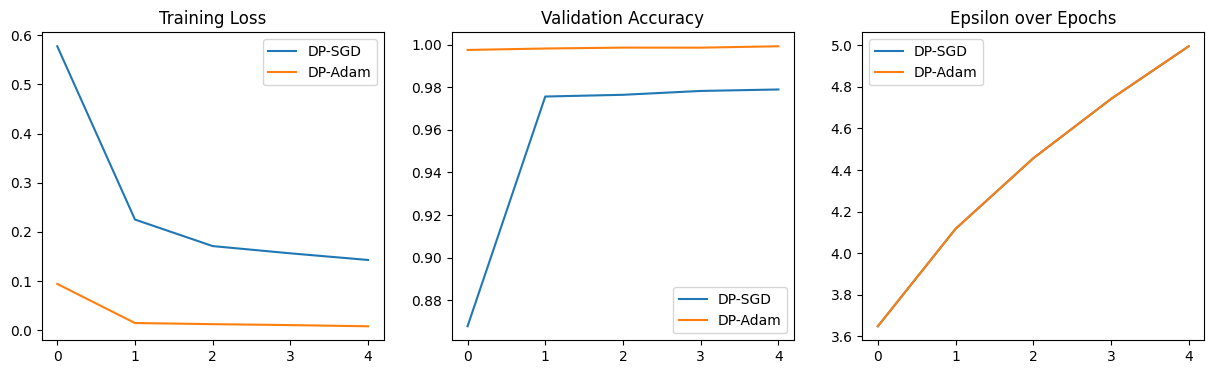

DP-SGD Confusion Matrix:
 [[     0      0   1573      0      0]
 [     0      0   1349      0      1]
 [     0      0 141503    537     20]
 [     0      0      0   8889      0]
 [     0      0      0      0   9865]]
DP-Adam Confusion Matrix:
 [[  1573      0      0      0      0]
 [     0   1258     90      0      2]
 [     0      9 142000     51      0]
 [     0      0      0   8889      0]
 [     0      0      0      0   9865]]


In [18]:
# 4. 训练函数 (支持 DP-SGD & DP-Adam)
# ================================
def train_and_evaluate(train_loader, val_loader, test_loader, optimizer_type="SGD",
                       input_dim=11, num_classes=5, epochs=5, lr=1e-3,
                       max_grad_norm=1.0, target_epsilon=5.0, target_delta=1e-5):

    model = DPCNNAttention(input_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("Unknown optimizer type")

    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        epochs=epochs,
        target_epsilon=target_epsilon,
        target_delta=target_delta,
        max_grad_norm=max_grad_norm,
    )

    train_losses, val_accs, epsilons = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0
        progress_bar = tqdm(train_loader, desc=f"[{optimizer_type}] Epoch {epoch+1}/{epochs}", leave=False)

        for feats, labels in progress_bar:
            feats, labels = feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(1)
            total_loss += loss.item() * labels.size(0)
            total_correct += (preds == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = total_correct / len(train_loader.dataset)
        train_losses.append(train_loss)

        # 验证
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for feats, labels in val_loader:
                feats, labels = feats.to(device), labels.to(device)
                outputs = model(feats)
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_acc = val_correct / val_total
        val_accs.append(val_acc)

        epsilon = privacy_engine.accountant.get_epsilon(delta=target_delta)
        epsilons.append(epsilon)
        print(f"[{optimizer_type}] Epoch {epoch+1}: Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, ε={epsilon:.2f}")

    # 测试
    model.eval()
    test_correct, test_total = 0, 0
    y_true_all, y_pred_all = [], []
    with torch.no_grad():
        for feats, labels in test_loader:
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            preds = outputs.argmax(1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
            y_true_all.extend(labels.cpu().numpy())
            y_pred_all.extend(preds.cpu().numpy())

    test_acc = test_correct / test_total
    test_f1 = f1_score(y_true_all, y_pred_all, average="macro")
    conf_mat = confusion_matrix(y_true_all, y_pred_all)
    print(f"[{optimizer_type}] Final Test Accuracy={test_acc:.4f}, F1-score={test_f1:.4f}, ε={epsilons[-1]:.2f}")

    return train_losses, val_accs, epsilons, test_acc, test_f1, conf_mat

# ================================
# 5. 实验对比入口
# ================================
def run_experiments(train_loader, val_loader, test_loader, input_dim, num_classes):
    results = {}
    for opt in ["SGD", "Adam"]:
        print(f"\n==== Running with DP-{opt} ====")
        train_losses, val_accs, epsilons, test_acc, test_f1, conf_mat = train_and_evaluate(
            train_loader, val_loader, test_loader,
            optimizer_type=opt,
            input_dim=input_dim,
            num_classes=num_classes
        )
        results[opt] = {"train_losses": train_losses,
                        "val_accs": val_accs,
                        "epsilons": epsilons,
                        "test_acc": test_acc,
                        "test_f1": test_f1,
                        "conf_mat": conf_mat}

    # 可视化
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(results["SGD"]["train_losses"], label="DP-SGD")
    plt.plot(results["Adam"]["train_losses"], label="DP-Adam")
    plt.title("Training Loss"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(results["SGD"]["val_accs"], label="DP-SGD")
    plt.plot(results["Adam"]["val_accs"], label="DP-Adam")
    plt.title("Validation Accuracy"); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(results["SGD"]["epsilons"], label="DP-SGD")
    plt.plot(results["Adam"]["epsilons"], label="DP-Adam")
    plt.title("Epsilon over Epochs"); plt.legend()
    plt.show()

    return results

# ================================
# 6. 运行实验
# ================================
results = run_experiments(train_loader, val_loader, test_loader,
                          input_dim=X_scaled.shape[2], num_classes=len(set(y_encoded)))

# 查看混淆矩阵
print("DP-SGD Confusion Matrix:\n", results["SGD"]["conf_mat"])
print("DP-Adam Confusion Matrix:\n", results["Adam"]["conf_mat"])